In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing,metrics 
from IPython.core.display import HTML
pd.set_option("display.max_columns",75)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
df=pd.read_csv('loan.csv')
df=df.dropna(axis=1,how='all')
numeric_data = df.select_dtypes(include=[np.number])
categorical_data = df.select_dtypes(exclude=[np.number])

print(numeric_data.shape)
print(categorical_data.shape)
print(df.dtypes.value_counts())


(2260668, 106)
(2260668, 36)
float64    102
object      36
int64        4
dtype: int64


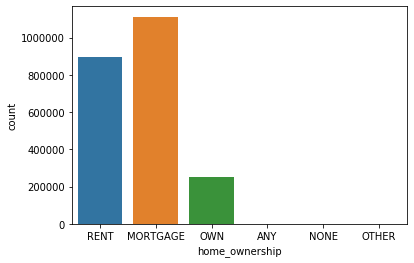

In [2]:
sns.countplot(df['home_ownership']);

In [3]:
listn=df['purpose'].unique().tolist()
print(listn)

['debt_consolidation', 'credit_card', 'house', 'car', 'other', 'vacation', 'home_improvement', 'small_business', 'major_purchase', 'medical', 'renewable_energy', 'moving', 'wedding', 'educational']


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

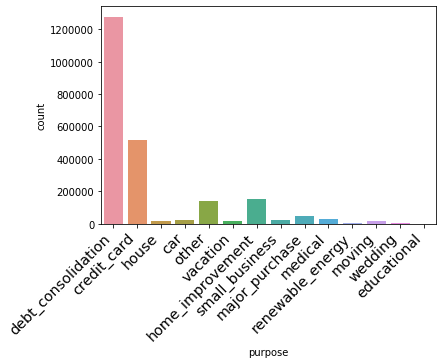

In [4]:
sns.countplot(df.purpose)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)

Text(0.5, 1.0, 'Total committed by Investors')

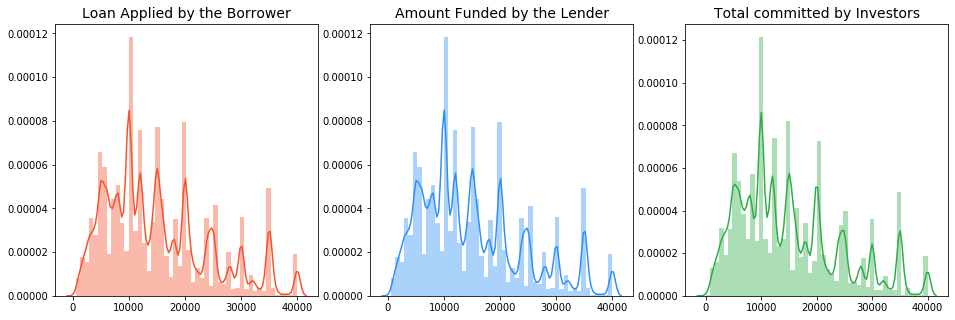

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))




loan_amount = df["loan_amnt"].values
funded_amount = df["funded_amnt"].values
investor_funds = df["funded_amnt_inv"].values


sns.distplot(loan_amount, ax=ax[0], color="#F7522F")
ax[0].set_title("Loan Applied by the Borrower", fontsize=14)
sns.distplot(funded_amount, ax=ax[1], color="#2F8FF7")
ax[1].set_title("Amount Funded by the Lender", fontsize=14)
sns.distplot(investor_funds, ax=ax[2], color="#2EAD46")
ax[2].set_title("Total committed by Investors", fontsize=14)

In [6]:
df['issue_d'].head()
dt_series = pd.to_datetime(df['issue_d'])
df['year'] = dt_series.dt.year

Text(0, 0.5, 'Average loan amount issued')

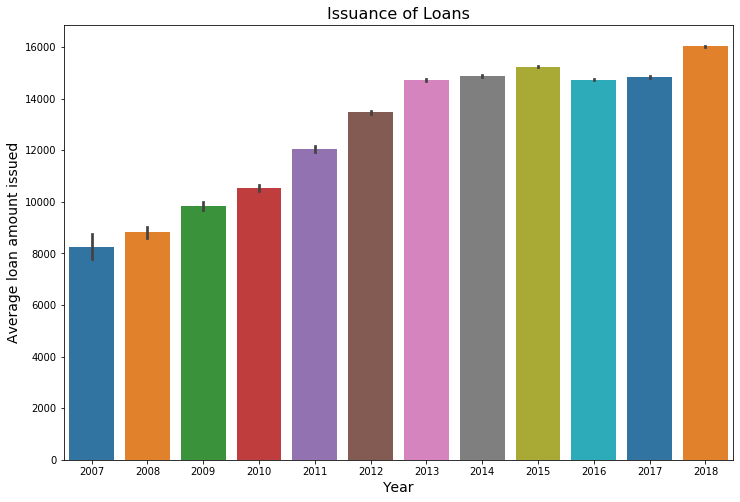

In [7]:
# The year of 2015 was the year were the highest amount of loans were issued 
# This is an indication that the economy is quiet recovering itself.
plt.figure(figsize=(12,8))
sns.barplot('year', 'loan_amnt', data=df, palette='tab10')
plt.title('Issuance of Loans', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average loan amount issued', fontsize=14)

Loan Statuses Counts


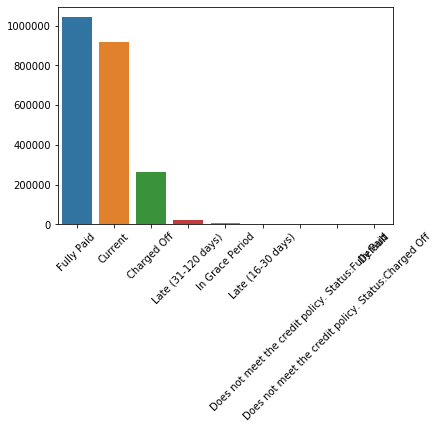

In [8]:
status_counts = df.loan_status.value_counts()
ax = sns.barplot(status_counts.index, status_counts.values)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
print("Loan Statuses Counts")

In [9]:
status_counts = df.loan_status.value_counts()

In [10]:
status_counts

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

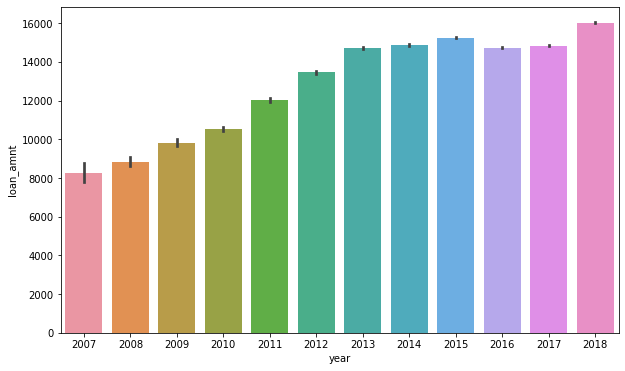

In [11]:
plt.figure(figsize=(10,6))
sns.barplot(df.year, df.loan_amnt)

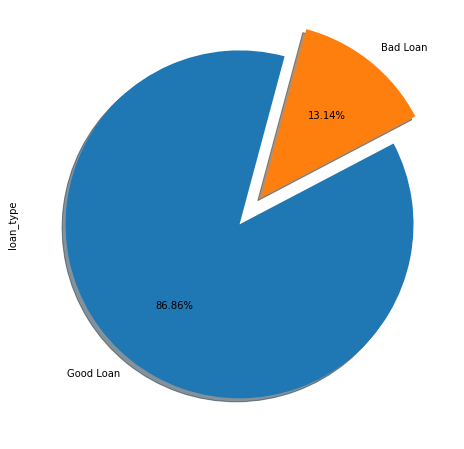

In [12]:
bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]
df['loan_type'] = np.nan

def loan_type(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'
    
df['loan_type'] = df['loan_status'].apply(loan_type)

plt.figure(figsize=(8,8))
df.loan_type.value_counts().plot.pie(explode = [0, 0.2],autopct='%1.2f%%', shadow = True, startangle = 75)

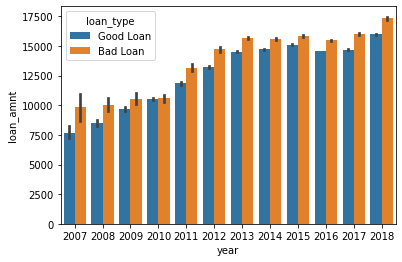

In [13]:
sns.barplot(x=df.year, y=df.loan_amnt, hue=df.loan_type)

In [14]:
df['addr_state'].unique()

# Make a list with each of the regions by state.

west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']



df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'
    


df['region'] = df['addr_state'].apply(finding_regions)

In [15]:
# This code will take the current date and transform it into a year-month format
df['complete_date'] = pd.to_datetime(df['issue_d'])

group_dates = df.groupby(['complete_date', 'region'], as_index=False).sum()

group_dates['issue_d'] = [month.to_period('M') for 
                          month in group_dates['complete_date']]

group_dates = group_dates.groupby(['issue_d', 'region'], as_index=False).sum()
group_dates = group_dates.groupby(['issue_d', 'region'], as_index=False).sum()
group_dates['loan_amnt'] = group_dates['loan_amnt']/1000


df_dates = pd.DataFrame(data=group_dates[['issue_d','region','loan_amnt']])

Text(0.5, 1.0, 'Loans issued by Region')

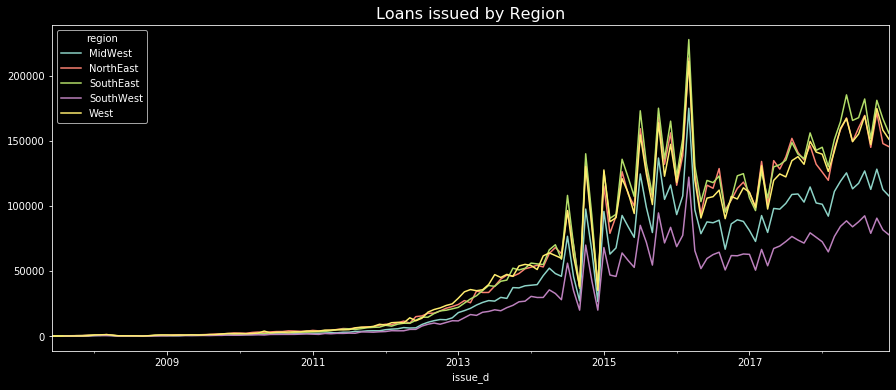

In [16]:
plt.style.use('dark_background')
cmap = plt.cm.Set3

by_issued_amnt = df_dates.groupby(['issue_d', 'region']).loan_amnt.sum()
by_issued_amnt.unstack().plot(stacked=False, colormap=cmap, grid=False, legend=True, figsize=(15,6))

plt.title('Loans issued by Region', fontsize=16)

In [17]:
employment_length = ['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
                    '4 years', '5 years', '6 years', '2 years', '7 years', 'n/a']

# Create a new column and convert emp_length to integers.

lst = [df]
df['emp_length_int'] = np.nan

for col in lst:
    col.loc[col['emp_length'] == '10+ years', "emp_length_int"] = 10
    col.loc[col['emp_length'] == '9 years', "emp_length_int"] = 9
    col.loc[col['emp_length'] == '8 years', "emp_length_int"] = 8
    col.loc[col['emp_length'] == '7 years', "emp_length_int"] = 7
    col.loc[col['emp_length'] == '6 years', "emp_length_int"] = 6
    col.loc[col['emp_length'] == '5 years', "emp_length_int"] = 5
    col.loc[col['emp_length'] == '4 years', "emp_length_int"] = 4
    col.loc[col['emp_length'] == '3 years', "emp_length_int"] = 3
    col.loc[col['emp_length'] == '2 years', "emp_length_int"] = 2
    col.loc[col['emp_length'] == '1 year', "emp_length_int"] = 1
    col.loc[col['emp_length'] == '< 1 year', "emp_length_int"] = 0.5
    col.loc[col['emp_length'] == 'n/a', "emp_length_int"] = 0

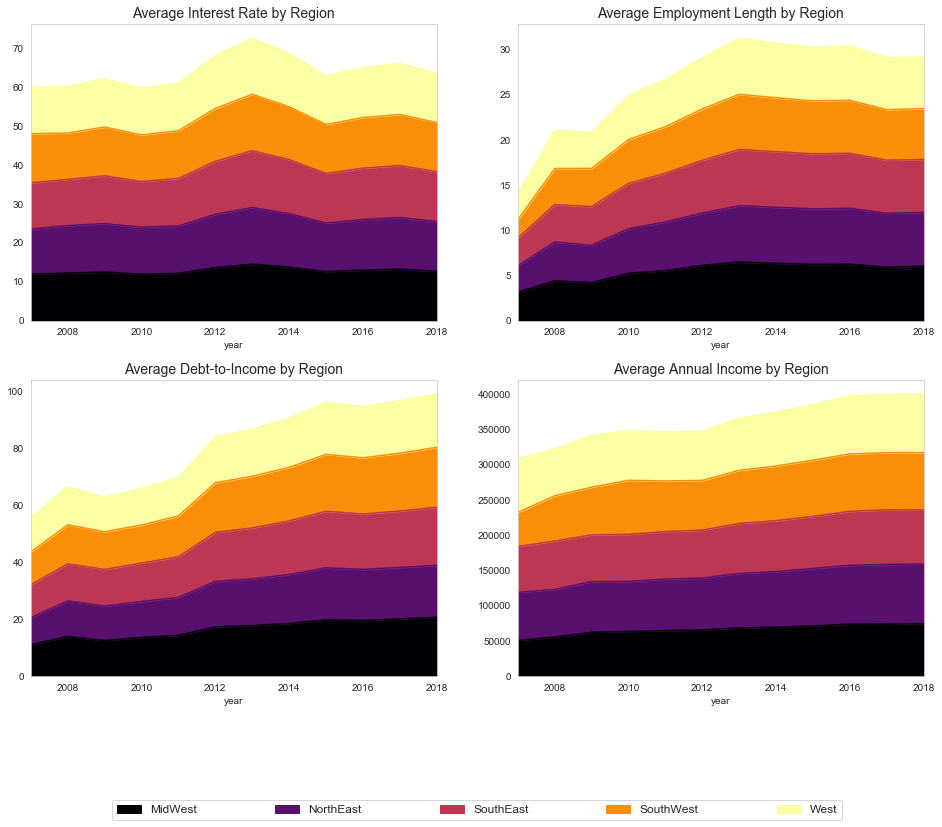

In [18]:
# Loan issued by Region and by Credit Score grade
# Change the colormap for tomorrow!

sns.set_style('whitegrid')

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
cmap = plt.cm.inferno

by_interest_rate = df.groupby(['year', 'region']).int_rate.mean()
by_interest_rate.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, legend=False, ax=ax1, figsize=(16,12))
ax1.set_title('Average Interest Rate by Region', fontsize=14)


by_employment_length = df.groupby(['year', 'region']).emp_length_int.mean()
by_employment_length.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, legend=False, ax=ax2, figsize=(16,12))
ax2.set_title('Average Employment Length by Region', fontsize=14)
# plt.xlabel('Year of Issuance', fontsize=14)

by_dti = df.groupby(['year', 'region']).dti.mean()
by_dti.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, legend=False, ax=ax3, figsize=(16,12))
ax3.set_title('Average Debt-to-Income by Region', fontsize=14)

by_income = df.groupby(['year', 'region']).annual_inc.mean()
by_income.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, ax=ax4, figsize=(16,12))
ax4.set_title('Average Annual Income by Region', fontsize=14)
ax4.legend(bbox_to_anchor=(-1.0, -0.5, 1.8, 0.1), loc=10,prop={'size':12},
           ncol=5, mode="expand", borderaxespad=0.)

In [19]:
# We have  297033 loans categorized as bad loans
badloans_df = df.loc[df["loan_type"] == "Bad Loan"]

# loan_status cross
loan_status_cross = pd.crosstab(badloans_df['region'], badloans_df['loan_status']).apply(lambda x: x/x.sum() * 100)
number_of_loanstatus = pd.crosstab(badloans_df['region'], badloans_df['loan_status'])


# Round our values
loan_status_cross['Charged Off'] = loan_status_cross['Charged Off'].apply(lambda x: round(x, 2))
loan_status_cross['Default'] = loan_status_cross['Default'].apply(lambda x: round(x, 2))
loan_status_cross['Does not meet the credit policy. Status:Charged Off'] = loan_status_cross['Does not meet the credit policy. Status:Charged Off'].apply(lambda x: round(x, 2))
loan_status_cross['In Grace Period'] = loan_status_cross['In Grace Period'].apply(lambda x: round(x, 2))
loan_status_cross['Late (16-30 days)'] = loan_status_cross['Late (16-30 days)'].apply(lambda x: round(x, 2))
loan_status_cross['Late (31-120 days)'] = loan_status_cross['Late (31-120 days)'].apply(lambda x: round(x, 2))


number_of_loanstatus['Total'] = number_of_loanstatus.sum(axis=1) 
# number_of_badloans
number_of_loanstatus

loan_status,Charged Off,Default,Does not meet the credit policy. Status:Charged Off,In Grace Period,Late (16-30 days),Late (31-120 days),Total
region,,,,,,,
MidWest,45202,9,142,1449,550,3609,50961
NorthEast,60827,7,190,2356,957,5356,69693
SouthEast,65460,5,184,2359,974,5596,74578
SouthWest,31833,4,79,1009,463,2794,36182
West,58333,6,166,1779,793,4542,65619


In [20]:
badloans_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297033 entries, 1777 to 2260661
Columns: 147 entries, loan_amnt to emp_length_int
dtypes: datetime64[ns](1), float64(103), int64(5), object(38)
memory usage: 335.4+ MB


In [21]:
# Let's create categories for annual_income since most of the bad loans are located below 100k

df['income_category'] = np.nan
lst = [df]

for col in lst:
    col.loc[col['annual_inc'] <= 100000, 'income_category'] = 'Low'
    col.loc[(col['annual_inc'] > 100000) & (col['annual_inc'] <= 200000), 'income_category'] = 'Medium'
    col.loc[col['annual_inc'] > 200000, 'income_category'] = 'High'

In [22]:
# Let's transform the column loan_condition into integrers.

lst = [df]
df['loan_type_int'] = np.nan

for col in lst:
    col.loc[df['loan_type'] == 'Good Loan', 'loan_type_int'] = 0 # Negative (Bad Loan)
    col.loc[df['loan_type'] == 'Bad Loan', 'loan_type_int'] = 1 # Positive (Good Loan)
    
# Convert from float to int the column (This is our label)  
df['loan_type_int'] = df['loan_type_int'].astype(int)

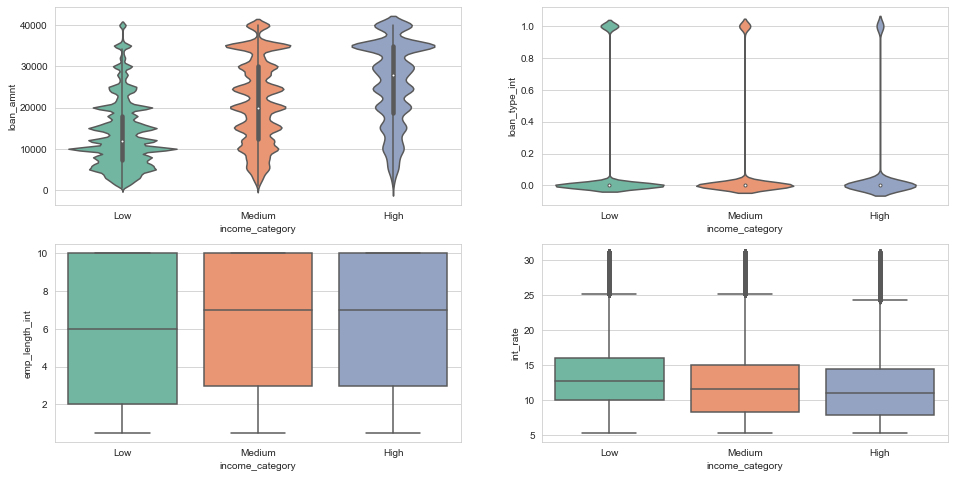

In [23]:
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(nrows=2, ncols=2, figsize=(16,8))



sns.violinplot(x="income_category", y="loan_amnt", data=df, palette="Set2", ax=ax1 )
sns.violinplot(x="income_category", y="loan_type_int", data=df, palette="Set2", ax=ax2)
sns.boxplot(x="income_category", y="emp_length_int", data=df, palette="Set2", ax=ax3)
sns.boxplot(x="income_category", y="int_rate", data=df, palette="Set2", ax=ax4)

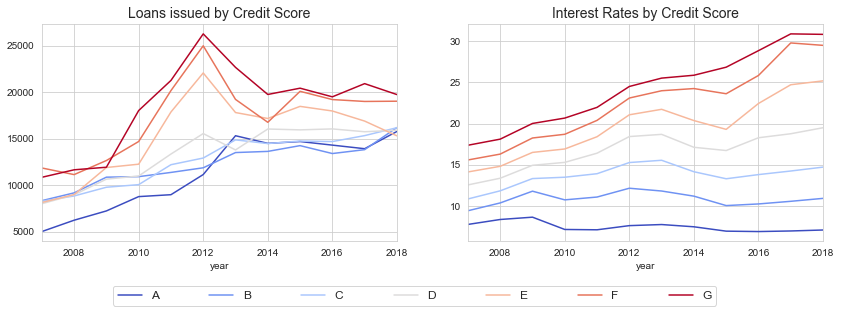

In [24]:
# Let's visualize how many loans were issued by creditscore
f, ((ax1, ax2)) = plt.subplots(1, 2)
cmap = plt.cm.coolwarm

by_credit_score = df.groupby(['year', 'grade']).loan_amnt.mean()
by_credit_score.unstack().plot(legend=False, ax=ax1, figsize=(14, 4), colormap=cmap)
ax1.set_title('Loans issued by Credit Score', fontsize=14)
    
    
by_inc = df.groupby(['year', 'grade']).int_rate.mean()
by_inc.unstack().plot(ax=ax2, figsize=(14, 4), colormap=cmap)
ax2.set_title('Interest Rates by Credit Score', fontsize=14)

ax2.legend(bbox_to_anchor=(-1.0, -0.3, 1.7, 0.1), loc=5, prop={'size':12},
           ncol=7, mode="expand", borderaxespad=0.)

Text(0, 0.5, 'Interest Rate (%)')

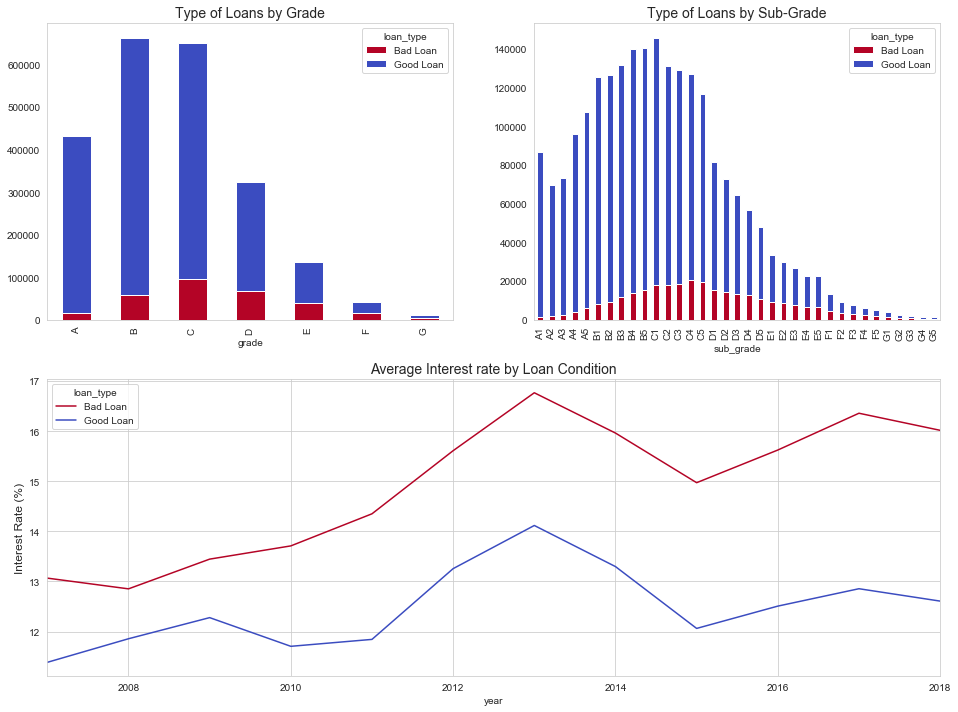

In [25]:
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

cmap = plt.cm.coolwarm_r

loans_by_region = df.groupby(['grade', 'loan_type']).size()
loans_by_region.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax1, grid=False)
ax1.set_title('Type of Loans by Grade', fontsize=14)


loans_by_grade = df.groupby(['sub_grade', 'loan_type']).size()
loans_by_grade.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax2, grid=False)
ax2.set_title('Type of Loans by Sub-Grade', fontsize=14)

by_interest = df.groupby(['year', 'loan_type']).int_rate.mean()
by_interest.unstack().plot(ax=ax3, colormap=cmap)
ax3.set_title('Average Interest rate by Loan Condition', fontsize=14)
ax3.set_ylabel('Interest Rate (%)', fontsize=12)

LOANS ISSUED, GROUPED BY CREDIT SCORE


<Figure size 1440x504 with 0 Axes>

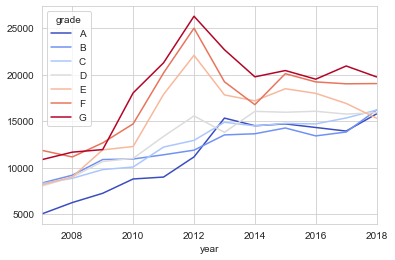

In [26]:
cmap = plt.cm.coolwarm
plt.figure(figsize=(20,7))

by_credit_score = df.groupby(['year', 'grade']).loan_amnt.mean()
by_credit_score.unstack().plot(colormap=cmap)
print("LOANS ISSUED, GROUPED BY CREDIT SCORE")

INTEREST RATES GROUPED BY CREDIT SCORE


<Figure size 1440x720 with 0 Axes>

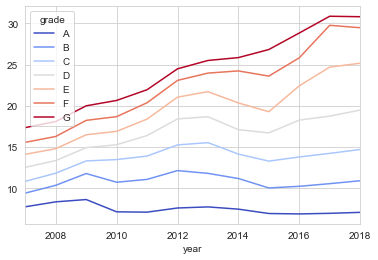

In [27]:
plt.figure(figsize=(20,10))
cmap = plt.cm.coolwarm

by_inc = df.groupby(['year', 'grade']).int_rate.mean()
by_inc.unstack().plot(colormap=cmap)
print("INTEREST RATES GROUPED BY CREDIT SCORE")

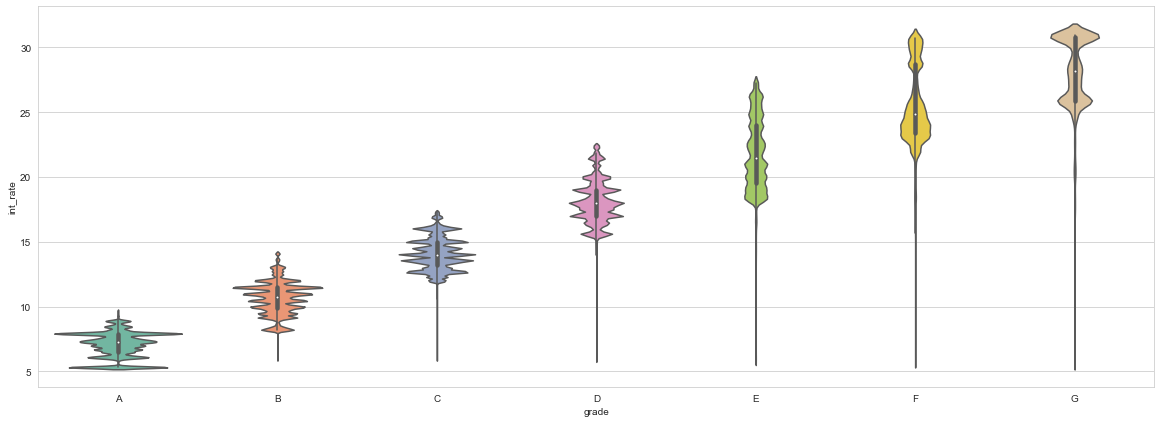

In [28]:
plt.figure(figsize=(20,7))
sns.violinplot(x='grade', y='int_rate', data=df, palette = "Set2", order=['A','B','C','D','E','F','G'])

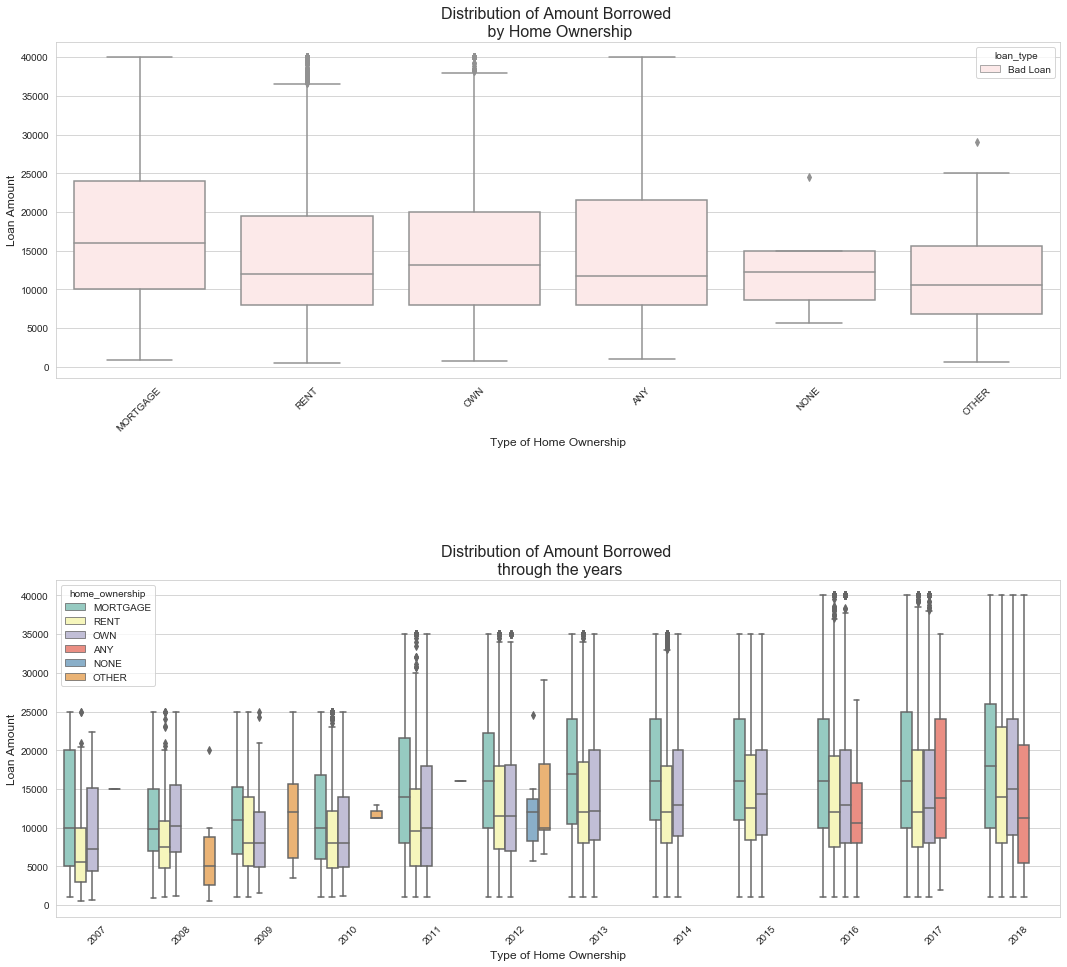

In [29]:
import seaborn as sns

plt.figure(figsize=(18,18))

bad_df = df.loc[df['loan_type'] == 'Bad Loan']

plt.subplot(211)
g = sns.boxplot(x='home_ownership', y='loan_amnt', hue='loan_type',
               data=bad_df, color='r')

g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("Type of Home Ownership", fontsize=12)
g.set_ylabel("Loan Amount", fontsize=12)
g.set_title("Distribution of Amount Borrowed \n by Home Ownership", fontsize=16)



plt.subplot(212)
g1 = sns.boxplot(x='year', y='loan_amnt', hue='home_ownership',
               data=bad_df, palette="Set3")
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("Type of Home Ownership", fontsize=12)
g1.set_ylabel("Loan Amount", fontsize=12)
g1.set_title("Distribution of Amount Borrowed \n through the years", fontsize=16)


plt.subplots_adjust(hspace = 0.6, top = 0.8)

plt.show()

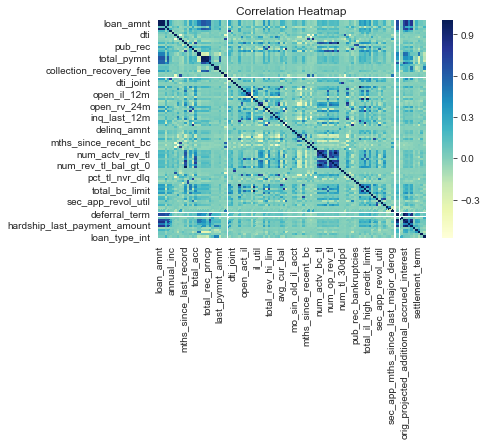

In [30]:
df_correlations = df.corr()

ax = plt.axes()
trace=sns.heatmap(df_correlations,cmap='YlGnBu')
ax.set_title('Correlation Heatmap')

plt.show()


In [31]:
#Modeling

# i have tried cleanig the data and get it ready for modeling, 
#although i have get rid of Nan valuse after spliting the data into train and test,
# i got the error that input has Nan values

In [32]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing,metrics 
from IPython.core.display import HTML
pd.set_option("display.max_columns",75)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

In [33]:
data_with_loanstatus_sliced = df[(df['loan_status']=="Fully Paid") | (df['loan_status']=="Charged Off")]
di = {"Fully Paid":0, "Charged Off":1}   #converting target variable to boolean
Dataset_withBoolTarget= data_with_loanstatus_sliced.replace({"loan_status": di})

In [34]:
Dataset_withBoolTarget['loan_status'].value_counts()
print("Current shape of dataset :",Dataset_withBoolTarget.shape)
Dataset_withBoolTarget.head(3)
print(Dataset_withBoolTarget.dtypes.value_counts())

Current shape of dataset : (1303607, 149)
float64           103
object             38
int64               7
datetime64[ns]      1
dtype: int64


In [35]:
dataset=Dataset_withBoolTarget.dropna(thresh = 340000,axis=1) #340000 is minimum number of non-NA values
print("Current shape of dataset :",dataset.shape)
dataset.head(3)
print(dataset.dtypes.value_counts())

Current shape of dataset : (1303607, 111)
float64           79
object            24
int64              7
datetime64[ns]     1
dtype: int64


In [36]:
features = ['funded_amnt','emp_length','annual_inc','home_ownership','grade',
            "last_pymnt_amnt", "mort_acc", "pub_rec", "int_rate", "open_acc","num_actv_rev_tl",
            "mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy",
            "avg_cur_bal","acc_open_past_24mths",'loan_status'] #'sub_grade' #selecting final features #'addr_state''tax_liens',
Final_data = dataset[features]
Final_data= Final_data.reset_index(drop=True)
print("Current shape of dataset :",Final_data.shape)
dataset.head(3)

Current shape of dataset : (1303607, 18)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,...,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,year,loan_type,region,complete_date,emp_length_int,income_category,loan_type_int
100,30000,30000,30000.0,36 months,22.35,1151.16,D,D5,Supervisor,5 years,MORTGAGE,100000.0,Source Verified,Dec-2018,0,n,debt_consolidation,Debt consolidation,917xx,CA,30.46,0.0,Jan-2012,0.0,51.0,11.0,1.0,15603,37.0,19.0,w,0.0,0.0,30026.44250,30026.44,30000.0,26.44,...,2.0,1.0,23.0,8.0,NaN,0.0,3.0,4.0,3.0,5.0,10.0,6.0,8.0,4.0,11.0,0.0,0.0,0.0,2.0,89.5,33.3,1.0,0.0,527120.0,98453.0,28600.0,101984.0,N,Cash,N,2018,Good Loan,West,2018-12-01,5.0,Low,0
152,40000,40000,40000.0,60 months,16.14,975.71,C,C4,Assistant to the Treasurer (Payroll),< 1 year,MORTGAGE,45000.0,Verified,Dec-2018,0,n,credit_card,Credit card refinancing,456xx,OH,50.53,0.0,Jun-2009,0.0,NaN,18.0,0.0,34971,64.5,37.0,w,0.0,0.0,40856.67896,40856.68,40000.0,856.68,...,2.0,1.0,2.0,9.0,NaN,0.0,7.0,9.0,7.0,7.0,26.0,9.0,10.0,9.0,18.0,0.0,0.0,0.0,4.0,100.0,42.9,0.0,0.0,344802.0,161720.0,45700.0,167965.0,N,Cash,N,2018,Good Loan,MidWest,2018-12-01,0.5,Low,0
170,20000,20000,20000.0,36 months,7.56,622.68,A,A3,Teacher,10+ years,MORTGAGE,100000.0,Not Verified,Dec-2018,0,n,credit_card,Credit card refinancing,982xx,WA,18.92,0.0,Feb-1999,0.0,48.0,9.0,0.0,25416,29.9,19.0,w,0.0,0.0,20215.79243,20215.79,20000.0,215.79,...,1.0,5.0,1.0,13.0,48.0,0.0,5.0,5.0,5.0,6.0,5.0,5.0,9.0,5.0,9.0,0.0,0.0,0.0,1.0,94.7,20.0,0.0,0.0,622183.0,71569.0,85100.0,74833.0,N,Cash,N,2018,Good Loan,West,2018-12-01,10.0,Low,0


In [37]:
print(Final_data.dtypes.value_counts())

float64    13
object      3
int64       2
dtype: int64


In [38]:
object_columns_df = Final_data.select_dtypes(include=["object"])
print (object_columns_df.iloc[0])


emp_length         5 years
home_ownership    MORTGAGE
grade                    D
Name: 0, dtype: object


In [39]:
float64_columns_df = Final_data.select_dtypes(include=["float64"])
print (float64_columns_df.iloc[0])

annual_inc               100000.00
last_pymnt_amnt           30082.32
mort_acc                      1.00
pub_rec                       1.00
int_rate                     22.35
open_acc                     11.00
num_actv_rev_tl               4.00
mo_sin_rcnt_rev_tl_op        23.00
mo_sin_old_rev_tl_op         73.00
bc_util                      46.90
bc_open_to_buy            15181.00
avg_cur_bal               42939.00
acc_open_past_24mths          4.00
Name: 0, dtype: float64


In [40]:
columns = [ 'emp_length', 'home_ownership', 'grade']
for col in columns:
    print (Final_data[col].value_counts())
    print (" ")

10+ years    428547
2 years      117820
< 1 year     104550
3 years      104200
1 year        85677
5 years       81623
4 years       78029
6 years       60933
8 years       59125
7 years       58145
9 years       49504
Name: emp_length, dtype: int64
 
MORTGAGE    645496
RENT        517808
OWN         139844
ANY            267
OTHER          144
NONE            48
Name: home_ownership, dtype: int64
 
B    380152
C    369928
A    226243
D    195280
E     91570
F     31483
G      8951
Name: grade, dtype: int64
 


In [41]:
Final_data['grade'] = Final_data['grade'].map({'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1})
Final_data["home_ownership"] = Final_data["home_ownership"].map({"MORTGAGE":6,"RENT":5,"OWN":4,"OTHER":3,"NONE":2,"ANY":1})
Final_data["emp_length"] = Final_data["emp_length"].replace({'years':'','year':'',' ':'','<':'','\+':'','n/a':'0'}, regex = True)
print("Current shape of dataset :",Final_data.shape)
Final_data.head()

Current shape of dataset : (1303607, 18)


,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status
0,30000,5,100000.0,6,4,30082.32,1.0,1.0,22.35,11.0,4.0,23.0,73.0,46.9,15181.0,42939.0,4.0,0
1,40000,1,45000.0,6,5,40910.48,1.0,0.0,16.14,18.0,9.0,2.0,70.0,67.3,14930.0,15059.0,5.0,0
2,20000,10,100000.0,6,7,20228.39,5.0,0.0,7.56,9.0,5.0,1.0,238.0,29.9,59684.0,57309.0,5.0,0
3,4500,10,38500.0,5,6,4553.46,0.0,0.0,11.31,12.0,5.0,2.0,69.0,28.9,10735.0,2428.0,8.0,0
4,8425,3,450000.0,6,3,8754.30,4.0,0.0,27.27,21.0,8.0,12.0,89.0,74.6,11632.0,34516.0,10.0,0


In [42]:
Final_data.fillna(Final_data.mean(),inplace = True)
HTML(Final_data.tail().to_html())
print("Current shape of dataset :",Final_data.shape)

Current shape of dataset : (1303607, 18)


In [43]:
scl = preprocessing.StandardScaler() #instance of preprocessing
fields = Final_data.columns.values[:-1]
data_clean = pd.DataFrame(scl.fit_transform(Final_data[fields]), columns = fields)
data_clean['loan_status'] = Final_data['loan_status']
data_clean['loan_status'].value_counts()

0    1041952
1     261655
Name: loan_status, dtype: int64

In [44]:
loanstatus_0 = data_clean[data_clean["loan_status"]==0]
loanstatus_1 = data_clean[data_clean["loan_status"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=5500)
subset_of_loanstatus_1 = loanstatus_1.sample(n=5500)
data_clean = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
data_clean = data_clean.sample(frac=1).reset_index(drop=True)
print("Current shape of dataset :",data_clean.shape)
data_clean.head()

Current shape of dataset : (11000, 18)


,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status
0,1.563099,1.108389,-0.250068,0.907249,1.350475,-0.647798,1.180235,-0.357498,-1.667294,0.074591,-0.512689,0.372786,-0.038092,-0.564454,1.925149,0.089970,-0.222749,1
1,1.793104,-1.419656,0.620153,0.907249,-0.191616,-0.735353,-0.851916,-0.357498,-0.098145,0.074591,0.110231,-0.257609,0.658618,0.399784,-0.138307,0.092493,-0.222749,0
2,0.068068,-0.576974,-0.436966,-0.572129,-0.962661,1.345150,-0.851916,-0.357498,0.784108,-1.023248,-1.447070,0.246707,-0.985182,-1.122698,-0.155602,-0.305463,0.097058,0
3,1.793104,1.108389,0.583036,0.907249,0.579430,3.308006,3.212386,-0.357498,-0.461549,0.074591,-0.201229,1.822694,0.930770,1.400273,-0.673896,0.837567,-0.222749,0
4,1.793104,-0.015186,0.411727,-2.051507,0.579430,-0.672456,0.672197,-0.357498,-0.266193,-0.108382,-0.201229,0.183667,0.005452,-0.491955,1.274064,0.420182,0.097058,1


In [45]:
data_clean.corr()

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status
funded_amnt,1.000000,0.095792,0.291425,0.129767,-0.177349,0.362123,0.220918,-0.046814,0.177994,0.179987,0.145643,0.026699,0.154407,0.057952,0.176771,0.202533,0.014828,0.077380
emp_length,0.095792,1.000000,0.062429,0.120337,-0.012718,0.047063,0.187719,0.036444,0.010323,0.028785,0.103856,0.017110,0.183584,0.019995,0.029226,0.092761,0.014878,-0.008005
annual_inc,0.291425,0.062429,1.000000,0.110141,0.058000,0.139626,0.202972,0.011433,-0.058064,0.134723,0.092164,0.023765,0.114704,0.005577,0.131575,0.254478,0.065670,-0.034101
home_ownership,0.129767,0.120337,0.110141,1.000000,0.050912,0.111734,0.386342,0.007481,-0.047822,0.075076,0.025986,0.019988,0.085742,0.047075,0.021030,0.335519,0.032900,-0.070048
grade,-0.177349,-0.012718,0.058000,0.050912,1.000000,0.022647,0.061577,-0.057340,-0.952714,-0.008124,-0.087802,0.114272,0.117331,-0.231093,0.233445,0.079251,-0.183814,-0.303175
last_pymnt_amnt,0.362123,0.047063,0.139626,0.111734,0.022647,1.000000,0.183955,-0.024825,-0.016996,0.076762,-0.011055,0.035650,0.075137,-0.042615,0.142965,0.172568,0.015931,-0.513752
mort_acc,0.220918,0.187719,0.202972,0.386342,0.061577,0.183955,1.000000,-0.012862,-0.068439,0.110771,0.042508,0.031542,0.279352,0.012098,0.114375,0.461219,0.052812,-0.101866
pub_rec,-0.046814,0.036444,0.011433,0.007481,-0.057340,-0.024825,-0.012862,1.000000,0.051514,-0.005201,0.005296,-0.058892,0.034562,-0.036810,-0.068953,-0.044179,0.085938,0.022838
int_rate,0.177994,0.010323,-0.058064,-0.047822,-0.952714,-0.016996,-0.068439,0.051514,1.000000,-0.001484,0.081329,-0.106250,-0.119489,0.230628,-0.234836,-0.076538,0.175080,0.298491
open_acc,0.179987,0.028785,0.134723,0.075076,-0.008124,0.076762,0.110771,-0.005201,-0.001484,1.000000,0.656249,-0.224959,0.121000,-0.082355,0.275368,-0.125515,0.502492,0.027964


In [46]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 18 columns):
funded_amnt              11000 non-null float64
emp_length               10280 non-null float64
annual_inc               11000 non-null float64
home_ownership           11000 non-null float64
grade                    11000 non-null float64
last_pymnt_amnt          11000 non-null float64
mort_acc                 11000 non-null float64
pub_rec                  11000 non-null float64
int_rate                 11000 non-null float64
open_acc                 11000 non-null float64
num_actv_rev_tl          11000 non-null float64
mo_sin_rcnt_rev_tl_op    11000 non-null float64
mo_sin_old_rev_tl_op     11000 non-null float64
bc_util                  11000 non-null float64
bc_open_to_buy           11000 non-null float64
avg_cur_bal              11000 non-null float64
acc_open_past_24mths     11000 non-null float64
loan_status              11000 non-null int64
dtypes: float64(17), int64(1)

In [47]:
import seaborn as sns
sns.set('talk', 'whitegrid', 'dark', font_scale=1, font='Ricty',rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
def plotAUC(truth, pred, lab):
    fpr, tpr, _ = metrics.roc_curve(truth,pred)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")


In [48]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, normalize=False): # This function prints and plots the confusion matrix.
    cm = confusion_matrix(y_test, model, labels=[0, 1])
    classes=["Will Pay", "Will Default"]
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [49]:
np.where(data_clean.values >= np.finfo(np.float64).max)
X_train, X_test, y_train, y_test = train_test_split(data_clean.iloc[:,:-1], data_clean.iloc[:,-1], test_size=0.2, random_state=42)
bs_train, bs_test = train_test_split(data_clean, test_size = 0.2, random_state=42) #just for bootstrapping

In [50]:
X_train.head()


,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths
10735,-0.506945,-0.296080,-0.302060,-0.572129,0.579430,-0.760538,-0.851916,-0.357498,-1.053918,-0.108382,1.044612,-0.509767,-1.344423,0.504908,-0.350934,-0.635486,-0.222749
5937,1.218092,1.108389,-0.103628,0.907249,-0.962661,2.102995,0.672197,-0.357498,0.905943,0.440538,-0.201229,0.246707,1.616594,0.153287,-0.511007,-0.072959,0.736672
7642,-0.751325,-1.419656,-0.787436,-0.572129,-0.191616,-0.727000,-0.851916,-0.357498,0.626563,-1.023248,-0.512689,0.246707,-1.235562,-0.412206,-0.142731,-0.741078,-0.542556
3328,-1.311962,-1.138762,-0.573300,-0.572129,-0.962661,-0.612652,-0.851916,-0.357498,0.494225,-1.206221,-1.135610,-0.572807,-1.148473,-0.426706,-0.314535,-0.756847,-0.862363
8681,-0.506945,-0.576974,-0.430542,-0.572129,1.350475,-0.721480,2.196310,-0.357498,-0.915278,0.440538,-0.512689,0.246707,0.266718,0.251161,-0.300190,-0.501446,-0.862363


**Feature Selection using RFE (Recursive Feature Elimination)**

in this one the error says i have nan values in input:

In [51]:
features = ['funded_amnt','annual_inc','grade',"last_pymnt_amnt", "int_rate",
            "mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy","acc_open_past_24mths","loan_status"]
X_train, X_test = X_train[features[:-1]], X_test[features[:-1]]
data_clean = data_clean[features]
print(X_train.shape)
print(data_clean.shape)

(8800, 10)
(11000, 11)


In [54]:
loanstatus_0 = data_clean[data_clean["loan_status"]==0]
loanstatus_1 = data_clean[data_clean["loan_status"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=5500)
subset_of_loanstatus_1 = loanstatus_1.sample(n=5500)
data_clean = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
data_clean = data_clean.sample(frac=1).reset_index(drop=True)
print("Current shape of dataset :",data_clean.shape)
data_clean.head()

Current shape of dataset : (11000, 11)


,funded_amnt,annual_inc,grade,last_pymnt_amnt,int_rate,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,acc_open_past_24mths,loan_status
0,-0.966954,0.054833,1.350475,-0.590672,-1.667294,-0.257609,-0.821891,-0.191084,-0.324255,-0.542556,0
1,0.873085,0.625863,-0.191616,2.023857,0.258958,-0.383688,0.114313,-0.854451,-0.257223,1.056479,0
2,0.183070,-0.230682,-0.191616,-0.711897,0.490024,-0.320649,1.801657,1.066777,-0.593055,0.736672,1
3,1.724103,-0.087924,-1.733707,-0.656828,1.414288,-0.761925,1.975835,1.295149,-0.567717,-0.222749,1
4,1.045588,-0.324962,1.350475,1.662621,-0.915278,0.372786,1.398872,-0.865326,1.375484,-0.862363,0


In [55]:
features = ['funded_amnt','annual_inc','grade',"last_pymnt_amnt", "int_rate",
            "mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy","acc_open_past_24mths","loan_status"]
X_train, X_test = X_train[features[:-1]], X_test[features[:-1]]
X_train.notnull().values.all()
np.isfinite(X_train).all()

X_train.isnull().values.any()
np.isnan(X_train).any()

data_clean = data_clean[features]
print(X_train.shape)
print(data_clean.shape)

(8800, 10)
(11000, 11)


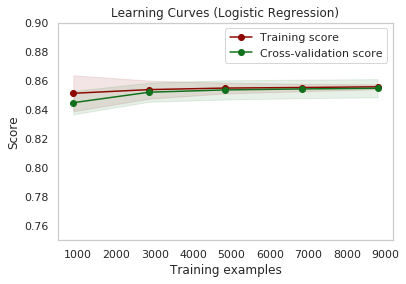

In [108]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
Ada_clf = AdaBoostClassifier(n_estimators=50)
scores = cross_val_score(Ada_clf, data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)
scores.mean()

import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

X, y = data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values
title = "Learning Curves (Logistic Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = linear_model.LogisticRegression()
plot_learning_curve(estimator, title, X, y, ylim=(0.75, 0.90), cv=cv, n_jobs=4)
plt.show()


In [109]:
import seaborn as sns
sns.set('talk', 'whitegrid', 'dark', font_scale=1, font='Ricty',rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
def plotAUC(truth, pred, lab):
    fpr, tpr, _ = metrics.roc_curve(truth,pred)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")

In [110]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, normalize=False): # This function prints and plots the confusion matrix.
    cm = confusion_matrix(y_test, model, labels=[0, 1])
    classes=["Will Pay", "Will Default"]
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [111]:
X_train, X_test, y_train, y_test = train_test_split(data_clean.iloc[:,:-1], data_clean.iloc[:,-1], test_size=0.2, random_state=42)
bs_train, bs_test = train_test_split(data_clean, test_size = 0.2, random_state=42) #just for bootstrapping

In [112]:
X_train.head()


,funded_amnt,annual_inc,grade,last_pymnt_amnt,int_rate,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,acc_open_past_24mths
10735,-0.276940,-0.159303,1.350475,-0.256852,-1.190457,7.510227e-01,-6.803715e-01,-8.544511e-01,4.918637e-01,-1.182170e+00
5937,-0.621947,0.240418,1.350475,-0.573223,-1.331197,2.011813e+00,-6.912576e-01,1.233525e+00,-6.408488e-01,-1.182170e+00
7642,-0.368942,2.267574,-0.962661,0.454283,0.502627,-4.479226e-16,6.188027e-16,9.452773e-14,4.877245e-16,-2.840457e-16
3328,-1.380963,-0.480507,0.579430,-0.764314,0.057300,1.206276e-01,-7.674603e-01,-1.434444e+00,-4.016104e-01,-2.227489e-01
8681,-0.506945,-0.570511,0.579430,-0.719795,-0.392229,-3.206489e-01,2.084696e+00,7.985297e-01,-6.021041e-01,-8.623630e-01


In [113]:
from sklearn.feature_selection import RFE
# create the RFE model and select 3 attributes
clf_LR = linear_model.LogisticRegression(C=1e30)
clf_LR.fit(X_train,y_train)
rfe = RFE(clf_LR, 10)
rfe = rfe.fit(data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)
# ['funded_amnt','emp_length','annual_inc','home_ownership','grade',"last_pymnt_amnt", "mort_acc", "pub_rec", 
# "int_rate", "open_acc","num_actv_rev_tl","mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy",
#"avg_cur_bal","acc_open_past_24mths",'loan_status']

[ True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1]


In [114]:
#PCA (Principal Component Analysis)
from sklearn.decomposition import PCA 
pca = PCA(n_components=10, whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
print('Expected Variance is '+ str(explained_variance))

Expected Variance is [0.2387177  0.17441636 0.16018924 0.10399397 0.09062853 0.0785421
 0.06023761 0.05009401 0.03819202 0.00498847]


In [115]:
features = ['funded_amnt','annual_inc','grade',"last_pymnt_amnt", "int_rate",
            "mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy","acc_open_past_24mths","loan_status"]
X_train, X_test = X_train[features[:-1]], X_test[features[:-1]]
data_clean = data_clean[features]
print(X_train.shape)
print(data_clean.shape)

(8800, 10)
(11000, 11)


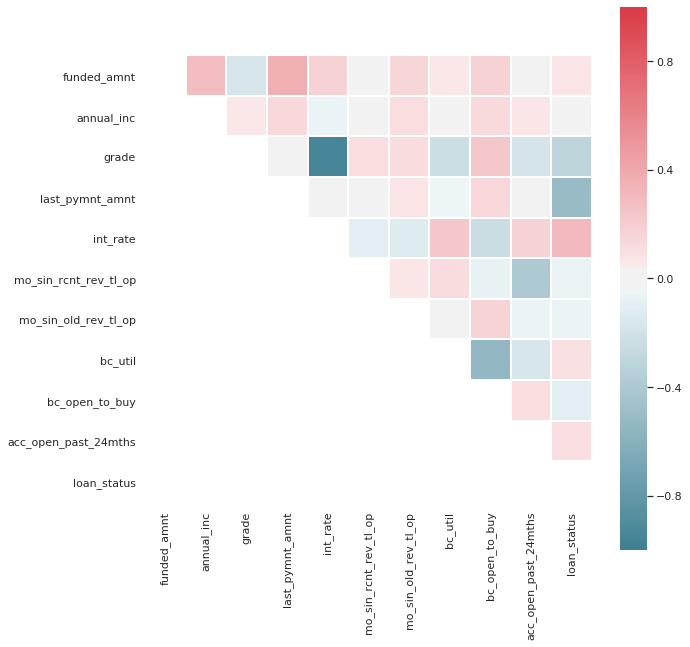

In [116]:
dataViz = data_clean
sns.set_context(context='notebook')
fig, ax = plt.subplots(figsize=(10,10)) 
corr = dataViz.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap,linewidths=1, vmin=-1, vmax=1, square=True, cbar=True, center=0, ax=ax, mask=mask)

In [85]:
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier(criterion='gini', random_state=0)
maxFeatures = range(1,data_clean.shape[1]-1)
param_dist = dict(max_features=maxFeatures)
rand = RandomizedSearchCV(rf, param_dist, cv=10, scoring='accuracy', n_iter=len(maxFeatures), random_state=10)
X=data_clean.iloc[:,:-1].values
y=data_clean.iloc[:,-1].values
rand.fit(X,y)
#print('Best Accuracy = '+str(rand.best_score_))
print(rand.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


In [86]:
randomForest = RandomForestClassifier(bootstrap=True,criterion = "gini",max_features=rand.best_estimator_.max_features,random_state=0 )
randomForest.fit(X_train,y_train)
rfPredict = randomForest.predict(X_test)
rfPredictproba = randomForest.predict_proba(X_test)[:,1] #for ROC curve
rfAccuracy = accuracy_score(y_test,rfPredict)
roc_score = metrics.roc_auc_score(y_test,rfPredict)
print(rfAccuracy)

0.8713636363636363


Text(0, 0.5, 'Normalized Gini Importance')

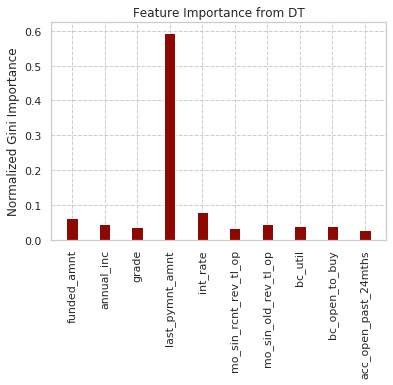

In [117]:
fig, ax = plt.subplots()
width=0.35
ax.bar(np.arange(len(features)-1), randomForest.feature_importances_, width, color='r')
ax.set_xticks(np.arange(len(randomForest.feature_importances_)))
ax.set_xticklabels(X_train.columns.values,rotation=90)
plt.title('Feature Importance from DT')
ax.set_ylabel('Normalized Gini Importance')

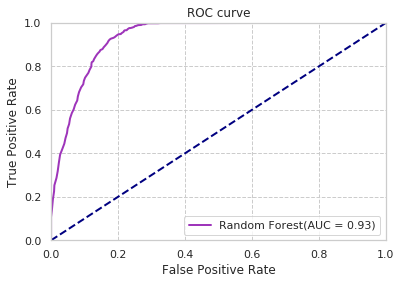

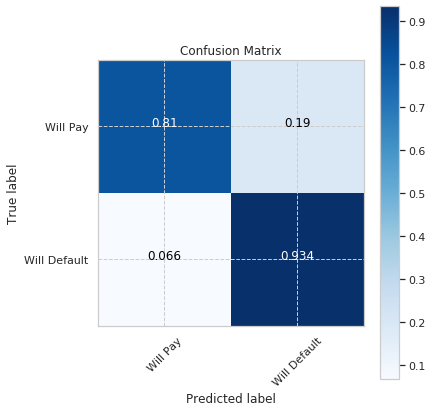

In [88]:
plotAUC(y_test,rfPredictproba, 'Random Forest')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(rfPredict, normalize=True)
plt.show()

In [91]:
from sklearn.model_selection import GridSearchCV
def cross_validation_best_parameters(model, param_grid):
    grid = GridSearchCV(model, param_grid,cv=10, scoring='accuracy')
    X=data_clean.iloc[:,:-1].values
    y=data_clean.iloc[:,-1].values
    grid.fit(X,y)
    return grid.best_score_,grid.best_estimator_
logreg = linear_model.LogisticRegression(random_state=0)
c=[0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(C=c)
Best_Accuracy, Best_classifier = cross_validation_best_parameters(logreg,param_grid)
print("Best accuracy is "+ str(Best_Accuracy))
print(Best_classifier)

Best accuracy is 0.8565454545454546
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Logistic regression accuracy is  0.8563636363636363


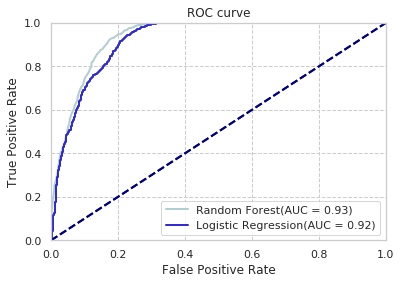

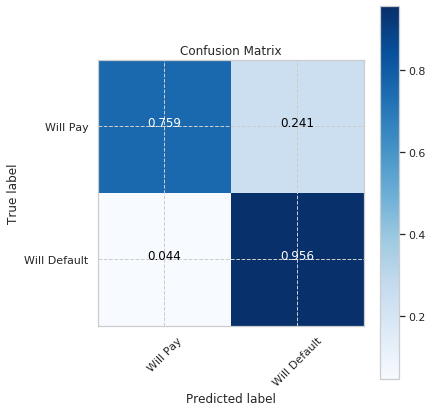

In [92]:
clf_LR = linear_model.LogisticRegression(C=Best_classifier.C)
clf_LR.fit(X_train,y_train)
LR_Predict = clf_LR.predict_proba(X_test)[:,1]
LR_Predict_bin = clf_LR.predict(X_test)
LR_Accuracy = accuracy_score(y_test,LR_Predict.round())
print("Logistic regression accuracy is ",LR_Accuracy)
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(LR_Predict_bin, normalize=True)
plt.show()

In [95]:
#KNN_Acc = knnfunc(2,10) - 74.8 max, 75.7 for 15, 25 - 76.2, 30 - 76.1
from sklearn.model_selection import GridSearchCV    ## takes too much time to run this cell.
clf_knn = KNeighborsClassifier()
k_range = list(range(35, 50))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(clf_knn, param_grid, cv=10, scoring='accuracy')
grid.fit(data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)
print(grid.best_params_)
print("---------------")
print(grid.best_estimator_)

{'n_neighbors': 40}
---------------
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=40, p=2,
                     weights='uniform')


 40
KNN accuracy is  0.8013636363636364


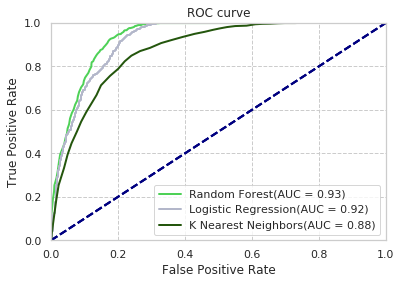

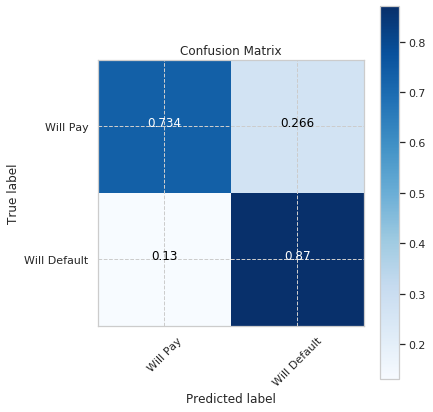

In [97]:
print("",grid.best_params_['n_neighbors'])
clf_knn_final = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])   #taking the the best from the above cell and using it to find predictions
clf_knn_final.fit(X_train,y_train)
knn_pred = clf_knn_final.predict(X_test)
KNN_Acc = accuracy_score(y_test,knn_pred)
print("KNN accuracy is ",KNN_Acc)
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plotAUC(y_test,knn_predictproba,'K Nearest Neighbors')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(knn_pred, normalize=True)
plt.show()

In [98]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
num_trees = 100
model = BaggingClassifier(base_estimator=randomForest, n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values, cv=kfold)
print(results.mean())

0.8766363636363635


In [125]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
#num_trees = 100
model = BaggingClassifier(base_estimator=clf_LR, random_state=seed)
results = model_selection.cross_val_score(model, data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values, cv=kfold)
print(results.mean())

from sklearn.model_selection import GridSearchCV    ## takes too much time to run this cell.
clf_svm = svm.SVC()
powers = range(0,5)
cs = [10**i for i in powers]
param_grid = dict(C=cs)
grid = GridSearchCV(clf_svm, param_grid, cv=10, scoring='accuracy')
grid.fit(data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)
print(grid.best_params_)
print("---------------")
print(grid.best_estimator_)

{'C': 10}
---------------
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


0.8581818181818182


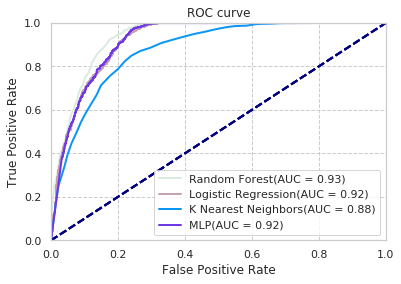

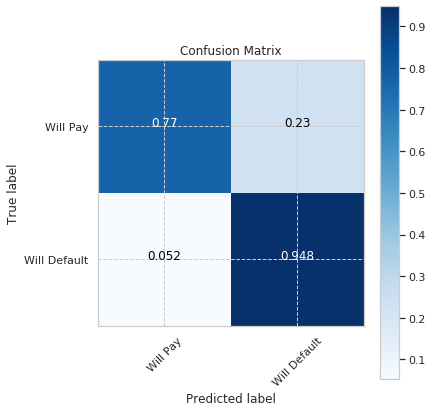

In [101]:
from sklearn.neural_network import MLPClassifier
clf_NN = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
clf_NN.fit(X_train,y_train)     
predict_NN = clf_NN.predict(X_test)
predictproba_NN = clf_NN.predict_proba(X_test)[:,1]
NNAccuracy = accuracy_score(y_test,predict_NN)
print(NNAccuracy)
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plotAUC(y_test,knn_predictproba,'K Nearest Neighbors')
plotAUC(y_test,predictproba_NN,'MLP')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(predict_NN, normalize=True)
plt.show()

SVM accuracy is  0.865


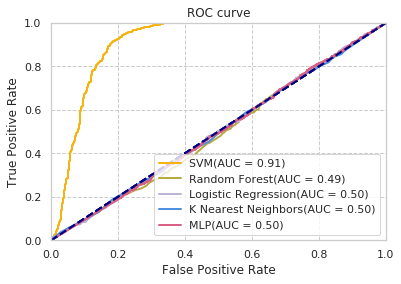

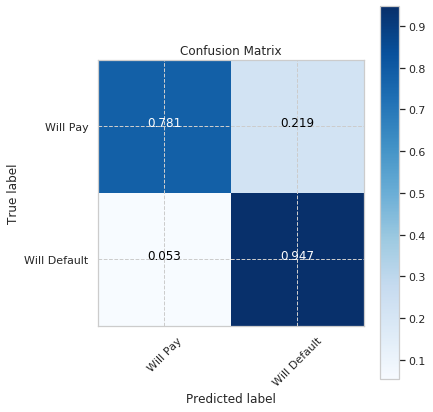

In [135]:
clf_svm = svm.SVC(kernel = "rbf", C=grid.best_estimator_.C)
clf_svm.fit(X_train.iloc[:,:],y_train)
predictions_svm = clf_svm.predict(X_test.iloc[:,:])
predictproba_svm = clf_svm.decision_function(X_test.iloc[:,:])
SVM_Accuracy = accuracy_score(y_test,predictions_svm)
print("SVM accuracy is ",SVM_Accuracy)
plotAUC(y_test,predictproba_svm, 'SVM')
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plotAUC(y_test,knn_predictproba,'K Nearest Neighbors')
plotAUC(y_test,predictproba_NN,'MLP')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(predictions_svm, normalize=True)
plt.show()

In [133]:
from sklearn.metrics import classification_report
print("RF",classification_report(y_test, rfPredict, target_names=None))
print("LR",classification_report(y_test, LR_Predict_bin, target_names=None))
print("SVM",classification_report(y_test, predictions_svm, target_names=None))
print("KNN",classification_report(y_test, knn_pred, target_names=None))
print("MLP",classification_report(y_test, predict_NN, target_names=None))

RF               precision    recall  f1-score   support

           0       0.49      0.44      0.46      1086
           1       0.50      0.55      0.53      1114

    accuracy                           0.50      2200
   macro avg       0.50      0.50      0.49      2200
weighted avg       0.50      0.50      0.49      2200

LR               precision    recall  f1-score   support

           0       0.49      0.41      0.45      1086
           1       0.51      0.60      0.55      1114

    accuracy                           0.50      2200
   macro avg       0.50      0.50      0.50      2200
weighted avg       0.50      0.50      0.50      2200

SVM               precision    recall  f1-score   support

           0       0.93      0.78      0.85      1086
           1       0.82      0.95      0.88      1114

    accuracy                           0.86      2200
   macro avg       0.88      0.86      0.86      2200
weighted avg       0.87      0.86      0.86      2200

KNN      

In [134]:
def modBootstrapper(train, test, nruns, sampsize, model, c):
    target = 'loan_status'
    aucs_boot = []
    for i in range(nruns):
        train_samp = train.iloc[np.random.randint(0, len(train), size = sampsize)] #selecting random indexes for KFold
        if (model == "LR"):
            lr_i = linear_model.LogisticRegression(C = 1e30)
            lr_i.fit(train_samp.drop(target,1), train_samp[target]) #Logistic regression
            p = lr_i.predict_proba(test.drop(target,1))[:,1]
        elif (model == "SVM"):
            svm_i = svm.SVC(kernel='rbf', C = c) 
            svm_i.fit(train_samp.drop(target,1), train_samp[target])#SVM fitting and predicting if lr==0
            p = svm_i.decision_function(test.drop(target,1))
        elif (model == "RF"):
            RF_i = RandomForestClassifier(bootstrap=True,criterion = "gini")
            RF_i.fit(train_samp.drop(target,1), train_samp[target])
            p = RF_i.predict_proba(X_test)[:,1]
        elif (model == "KNN"):
            knn_i = KNeighborsClassifier(n_neighbors= 30) #taking the the best from the above cell and using it to find predictions
            knn_i.fit(train_samp.drop(target,1), train_samp[target])
            p = knn_i.predict_proba(X_test)[:,1]
            
        aucs_boot.append(metrics.roc_auc_score(test[target], p)) #calculating auc scores for each bag in bootstrapping
    
    return [np.mean(aucs_boot), np.sqrt(np.var(aucs_boot))] #mean, standard error = square root of variance

In [129]:
bs_train, bs_test = train_test_split(data_clean, test_size = 0.2, random_state=42) #just for bootstrapping
SampleSizes = [250,1000,1500,2000,2750,3750,4500,5200,6500,7000,8000,8500,9000,10000,11000] #various samples of Dataset
LR_means = []
Lr_stderr = []
svm_means = []
svm_stderr = []
RF_means = []
RF_stderr = []
KNN_means = []
KNN_stderr = []
for n in SampleSizes:
    mean, err = modBootstrapper(bs_train, bs_test, 20, n, "LR", 0.1)# collecting means and stderrs for LR model
    LR_means.append(mean)
    Lr_stderr.append(err)
    mean2, err2 = modBootstrapper(bs_train, bs_test, 20, n,"SVM", 0.1)# collecting means and stderrs for SVM model
    svm_means.append(mean2)
    svm_stderr.append(err2)
    mean3, err3 = modBootstrapper(bs_train, bs_test, 20, n,"RF", 0.1)# collecting means and stderrs for SVM model
    RF_means.append(mean3)
    RF_stderr.append(err3)
    mean4, err4 = modBootstrapper(bs_train, bs_test, 20, n,"KNN", 0.1)# collecting means and stderrs for SVM model
    KNN_means.append(mean4)
    KNN_stderr.append(err4)
    print(n)

250
1000
1500
2000
2750
3750
4500
5200
6500
7000
8000
8500
9000
10000
11000


Text(0, 0.5, 'roc_auc_score')

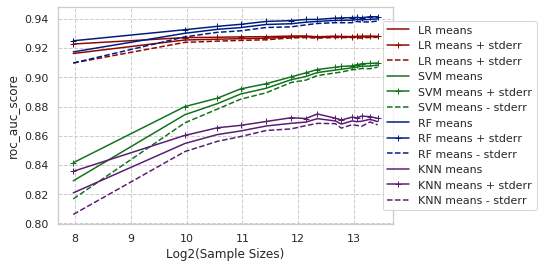

In [131]:
plt.plot(np.log2(SampleSizes), LR_means, 'r', label = 'LR means')
plt.plot(np.log2(SampleSizes), LR_means + np.array(Lr_stderr), 'r+-', label = 'LR means + stderr')
plt.plot(np.log2(SampleSizes), LR_means - np.array(Lr_stderr), 'r--',  label = 'LR means + stderr')

plt.plot(np.log2(SampleSizes), svm_means, 'g', label = 'SVM means')
plt.plot(np.log2(SampleSizes), svm_means + np.array(svm_stderr), 'g+-', label = 'SVM means + stderr')
plt.plot(np.log2(SampleSizes), svm_means - np.array(svm_stderr), 'g--', label = 'SVM means - stderr')

plt.plot(np.log2(SampleSizes), RF_means, 'b', label = 'RF means')
plt.plot(np.log2(SampleSizes), RF_means + np.array(RF_stderr), 'b+-', label = 'RF means + stderr')
plt.plot(np.log2(SampleSizes), RF_means - np.array(RF_stderr), 'b--', label = 'RF means - stderr')

plt.plot(np.log2(SampleSizes), KNN_means, 'm', label = 'KNN means')
plt.plot(np.log2(SampleSizes), KNN_means + np.array(KNN_stderr), 'm+-', label = 'KNN means + stderr')
plt.plot(np.log2(SampleSizes), KNN_means - np.array(KNN_stderr), 'm--', label = 'KNN means - stderr')

plt.legend(bbox_to_anchor=(1.20, 0.5),loc = 10)
plt.xlabel('Log2(Sample Sizes)')
plt.ylabel('roc_auc_score')
